### Supervised categorical encodings

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
train = pd.read_csv("data/amazon-employee-access-challenge/train.csv")
test = pd.read_csv("data/amazon-employee-access-challenge/test.csv")

In [3]:
target = "ACTION"
col4train = [x for x in train.columns if x not in [target, "ROLE_TITLE"]]
y = train[target].values

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier

def get_model():
    params = {
        "n_estimators" : 300,
        "n_jobs" : 3,
        "random_state":5436,
    }
    return ExtraTreesClassifier(**params)

### Simple Target Encoding
타겟의 평균으로 각 고유값을 인코딩

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
class TargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names ):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
    
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            self.learned_values[c] = (X_[[c, "__target__"]]
                                     .groupby(c)["__target__"].mean()
                                     .reset_index())
        self.dataset_mean = np.mean(y)
        return self
    
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                               .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
            transformed_X = transformed_X.fillna(self.dataset_mean)
            return transformed_X
        
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
        return self.transform(X)
    

In [18]:
skf = StratifiedKFold(n_splits=5, random_state=5451, shuffle=True)
te = TargetEncoding(columns_names=col4train)
X_tr = te.fit_transform(train, y).values

scores = []
tr_scores = []
for train_index, test_index in skf.split(train, y):
    train_df, valid_df = X_tr[train_index], X_tr[test_index]
    train_y, valid_y = y[train_index], y[test_index]
    
    model = get_model()
    model.fit(train_df, train_y)
    
    predictions = model.predict_proba(valid_df)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))
    
    train_preds = model.predict_proba(train_df)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))
    
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)))

Train AUC score: 1.0000 Valid AUC score: 0.9313, STD: 0.0035


### Target Encoding Smoothing

    k : 변곡점(inflection point) f(x) = 0.5
    f : 기울기(steepness)

In [13]:
class TargetEncodingSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names, k, f):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
        self.k = k 
        self.f = f 
    def smoothing_func(self, N):
        return 1 / ( 1 + np.exp(-(N-self.k)/self.f))
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        self.dataset_mean = np.mean(y)
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            stats = (X_[[c, "__target__"]]
                    .groupby(c)["__target__"]
                    .agg(['mean','size']))
            stats["alpha"] = self.smoothing_func(stats["size"])
            stats["__target__"] = (stats["alpha"]*stats["mean"]
                                   + (1-stats["alpha"])*self.dataset_mean)
            stats = (stats
                     .drop([x for x in stats.columns if x not in ["__target__", c]], axis = 1)
                     .reset_index())
            self.learned_values[c] = stats
        self.dataset_mean = np.mean(y)
        return self
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
        return self.transform(X)
        

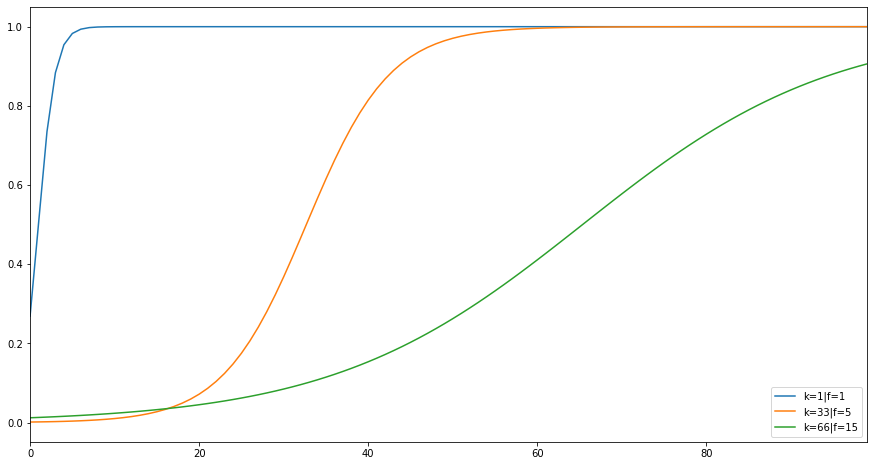

In [10]:
%matplotlib inline
x = np.linspace(0,100,100)
plot = pd.DataFrame()

te = TargetEncodingSmoothing([], 1,1)
plot["k=1|f=1"] = te.smoothing_func(x)

te = TargetEncodingSmoothing([], 33,5)
plot["k=33|f=5"] = te.smoothing_func(x)

te = TargetEncodingSmoothing([], 66,15)
plot["k=66|f=15"] = te.smoothing_func(x)

plot.plot(figsize = (15,8))

In [14]:
skf = StratifiedKFold(n_splits=5, random_state=5451, shuffle=True)
te = TargetEncoding(columns_names=col4train)
X_tr = te.fit_transform(train, y).values


scores = []
tr_scores = []
for train_index, test_index in skf.split(train, y):
    train_df = train.loc[train_index,col4train].reset_index(drop = True)
    valid_df = train.loc[test_index,col4train].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]
    te = TargetEncodingSmoothing(
        columns_names= col4train,
        k = 3, f = 1.5
    )
    X_tr = te.fit_transform(train_df, train_y).values
    X_val = te.transform(valid_df).values

    model = get_model()
    model.fit(X_tr,train_y)

    predictions = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(X_tr)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))

print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))

Train AUC score: 1.0000 Valid AUC score: 0.7906, STD: 0.0065


### Adding noise. CV inside CV


In [21]:
def get_CV_target_encoding(data, y, encoder, cv = 5):
    skfTE = StratifiedKFold(n_splits=cv, random_state = 545167, shuffle = True)
    result = []
    for train_indexTE, test_indexTE in skfTE.split(data, y):
        encoder.fit(data.iloc[train_indexTE,:].reset_index(drop = True), y[train_indexTE])
        tmp =  encoder.transform(data.iloc[test_indexTE,:].reset_index(drop = True))
        tmp["index"] = test_indexTE
        result.append(tmp)
    result = pd.concat(result, ignore_index = True)
    result = result.sort_values('index').reset_index(drop = True).drop('index', axis = 1)
    return result

In [22]:
scores = []
tr_scores = []
for train_index, test_index in skf.split(train, y):
    train_df = train.loc[train_index,col4train].reset_index(drop = True)
    valid_df = train.loc[test_index,col4train].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]
    te = TargetEncodingSmoothing(
        columns_names= col4train,
        k = 3, f = 1.5
    )
    
    X_tr = get_CV_target_encoding(train_df, train_y, te, cv = 5)

    te.fit(train_df, train_y)
    X_val = te.transform(valid_df).values

    model = get_model()
    model.fit(X_tr,train_y)

    predictions = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(X_tr)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))

print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))

Train AUC score: 1.0000 Valid AUC score: 0.8781, STD: 0.0039


### Adding noise. Expanding mean.

In [15]:
class TargetEncodingExpandingMean(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        self.dataset_mean = np.mean(y)
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            stats = (X_[[c,"__target__"]]
                     .groupby(c)["__target__"]
                     .agg(['mean', 'size'])) #
            stats["__target__"] = stats["mean"]
            stats = (stats
                     .drop([x for x in stats.columns if x not in ["__target__",c]], axis = 1)
                     .reset_index())
            self.learned_values[c] = stats
        return self
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
    
        #Expanding mean transform
        X_ = X[self.columns_names].copy().reset_index(drop = True)
        X_["__target__"] = y
        X_["index"] = X_.index
        X_transformed = pd.DataFrame()
        for c in self.columns_names:
            X_shuffled = X_[[c,"__target__", "index"]].copy()
            X_shuffled = X_shuffled.sample(n = len(X_shuffled),replace=False)
            X_shuffled["cnt"] = 1
            X_shuffled["cumsum"] = (X_shuffled
                                    .groupby(c,sort=False)['__target__']
                                    .apply(lambda x : x.shift().cumsum()))
            X_shuffled["cumcnt"] = (X_shuffled
                                    .groupby(c,sort=False)['cnt']
                                    .apply(lambda x : x.shift().cumsum()))
            X_shuffled["encoded"] = X_shuffled["cumsum"] / X_shuffled["cumcnt"]
            X_shuffled["encoded"] = X_shuffled["encoded"].fillna(self.dataset_mean)
            X_transformed[c] = X_shuffled.sort_values("index")["encoded"].values
        return X_transformed

In [16]:
scores = []
tr_scores = []
for train_index, test_index in skf.split(train, y):
    train_df = train.loc[train_index,col4train].reset_index(drop = True)
    valid_df = train.loc[test_index,col4train].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]
    te = TargetEncodingExpandingMean(columns_names=col4train)

    X_tr = te.fit_transform(train_df, train_y)
    X_val = te.transform(valid_df).values

    model = get_model()
    model.fit(X_tr,train_y)

    predictions = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(X_tr)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))

print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))

Train AUC score: 1.0000 Valid AUC score: 0.8444, STD: 0.0098


#### using feature pairs(create a new set of categorical features)

In [17]:
train[col4train] = train[col4train].values.astype(str)
test[col4train] = test[col4train].values.astype(str)

from itertools import combinations
new_col4train = col4train
for c1,c2 in combinations(col4train, 2):
    name = "{}_{}".format(c1,c2)
    new_col4train.append(name)
    train[name] = train[c1] + "_" + train[c2]
    test[name] = test[c1] + "_" + test[c2]

In [18]:
print(train[new_col4train].shape, test[new_col4train].shape)
train[new_col4train].head(5)

(32769, 36) (58921, 36)


,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,RESOURCE_MGR_ID,RESOURCE_ROLE_ROLLUP_1,...,ROLE_ROLLUP_2_ROLE_DEPTNAME,ROLE_ROLLUP_2_ROLE_FAMILY_DESC,ROLE_ROLLUP_2_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_DEPTNAME_ROLE_FAMILY,ROLE_DEPTNAME_ROLE_CODE,ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_FAMILY_DESC_ROLE_CODE,ROLE_FAMILY_ROLE_CODE
0,39353,85475,117961,118300,123472,117906,290919,117908,39353_85475,39353_117961,...,118300_123472,118300_117906,118300_290919,118300_117908,123472_117906,123472_290919,123472_117908,117906_290919,117906_117908,290919_117908
1,17183,1540,117961,118343,123125,118536,308574,118539,17183_1540,17183_117961,...,118343_123125,118343_118536,118343_308574,118343_118539,123125_118536,123125_308574,123125_118539,118536_308574,118536_118539,308574_118539
2,36724,14457,118219,118220,117884,267952,19721,117880,36724_14457,36724_118219,...,118220_117884,118220_267952,118220_19721,118220_117880,117884_267952,117884_19721,117884_117880,267952_19721,267952_117880,19721_117880
3,36135,5396,117961,118343,119993,240983,290919,118322,36135_5396,36135_117961,...,118343_119993,118343_240983,118343_290919,118343_118322,119993_240983,119993_290919,119993_118322,240983_290919,240983_118322,290919_118322
4,42680,5905,117929,117930,119569,123932,19793,119325,42680_5905,42680_117929,...,117930_119569,117930_123932,117930_19793,117930_119325,119569_123932,119569_19793,119569_119325,123932_19793,123932_119325,19793_119325


In [19]:
# 36개의 feature 확인

train[new_col4train].apply(lambda x: len(x.unique()))

RESOURCE                           7518
MGR_ID                             4243
ROLE_ROLLUP_1                       128
ROLE_ROLLUP_2                       177
ROLE_DEPTNAME                       449
ROLE_FAMILY_DESC                   2358
ROLE_FAMILY                          67
ROLE_CODE                           343
RESOURCE_MGR_ID                   27626
RESOURCE_ROLE_ROLLUP_1            11091
RESOURCE_ROLE_ROLLUP_2            13422
RESOURCE_ROLE_DEPTNAME            17354
RESOURCE_ROLE_FAMILY_DESC         22734
RESOURCE_ROLE_FAMILY              13195
RESOURCE_ROLE_CODE                19043
MGR_ID_ROLE_ROLLUP_1               4461
MGR_ID_ROLE_ROLLUP_2               4623
MGR_ID_ROLE_DEPTNAME               5045
MGR_ID_ROLE_FAMILY_DESC            7973
MGR_ID_ROLE_FAMILY                 5483
MGR_ID_ROLE_CODE                   7484
ROLE_ROLLUP_1_ROLE_ROLLUP_2         187
ROLE_ROLLUP_1_ROLE_DEPTNAME        1185
ROLE_ROLLUP_1_ROLE_FAMILY_DESC     3282
ROLE_ROLLUP_1_ROLE_FAMILY           750


In [ ]:
scores = []
tr_scores = []
for train_index, test_index in skf.split(train, y):
    train_df = train.loc[train_index,new_col4train].reset_index(drop = True)
    valid_df = train.loc[test_index,new_col4train].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]
    te = TargetEncodingExpandingMean(columns_names=new_col4train)

    X_tr = te.fit_transform(train_df, train_y)
    X_val = te.transform(valid_df)
    
    te2 = TargetEncodingSmoothing(
        columns_names= new_col4train,
        k = 3, f = 1.5,
    )
    
    X_tr2 = get_CV_target_encoding(train_df, train_y, te2, cv = 5)
    te2.fit(train_df, train_y)
    X_val2 = te2.transform(valid_df)
    
    X_tr = pd.concat([X_tr, X_tr2], axis = 1)
    X_val = pd.concat([X_val, X_val2], axis = 1)

    model = get_model()
    model.fit(X_tr,train_y)

    predictions = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(X_tr)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))

print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))

In [ ]:
te = TargetEncodingExpandingMean(columns_names=new_col4train)

X_tr = te.fit_transform(train[new_col4train], y)
X_val = te.transform(test[new_col4train])

te2 = TargetEncodingSmoothing(
    columns_names= new_col4train,
    k = 3, f = 1.5,
)

X_tr2 = get_CV_target_encoding(train[new_col4train], y, te2, cv = 5)
te2.fit(train[new_col4train], y)
X_val2 = te2.transform(test[new_col4train])

X = pd.concat([X_tr, X_tr2], axis = 1)
X_te = pd.concat([X_val, X_val2], axis = 1)

model = get_model()
model.fit(X,y)
predictions = model.predict_proba(X_te)[:,1]

submit = pd.DataFrame()
submit["Id"] = test["id"]
submit["ACTION"] = predictions

submit.to_csv("data/submission3.csv", index = False)